<a href="https://colab.research.google.com/github/Inteli-College/2024-2A-T05-CC09-G04/blob/classificacao-spriint3/EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras
!pip install tensorflow

Passo 1: Carregamento e Extração das Imagens RGB



In [ ]:
import pickle
import h5py
import numpy as np

# Função para carregar arquivos pkl
def load_pkl(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

# Função para carregar arquivo h5
def load_h5(file_path):
    with h5py.File(file_path, 'r') as f:
        data = np.array(f['X'])  # Assume que as imagens estão na chave 'X'
    return data

# Função para extrair apenas o índice 2 (imagem RGB) das tuplas de imagens
def extract_index_2_images(data):
    images = [item[2] for item in data if isinstance(item, tuple) and len(item) > 2]
    return images

# Carregar os arquivos de dados
path_train_com_cabeca = "/content/drive/MyDrive/dataset/com_cabeca/train.pkl"
path_test_com_cabeca = "/content/drive/MyDrive/dataset/com_cabeca/test.pkl"
path_sem_cabeca = "/content/drive/MyDrive/dataset/sem_cabeca/negative_X (1).h5"

# Carregar e extrair as imagens "com cabeça", mantendo apenas o índice 2 (RGB)
train_com_cabeca = load_pkl(path_train_com_cabeca)
test_com_cabeca = load_pkl(path_test_com_cabeca)
train_com_cabeca_images = extract_index_2_images(train_com_cabeca)
test_com_cabeca_images = extract_index_2_images(test_com_cabeca)

# Carregar as imagens "sem cabeça" do arquivo h5
sem_cabeca_images = load_h5(path_sem_cabeca)

sem_cabeca_images = sem_cabeca_images * 255

# Verificar as formas das imagens extraídas
print("Número de imagens com cabeça (treino):", len(train_com_cabeca_images))
print("Número de imagens com cabeça (teste):", len(test_com_cabeca_images))
print("Número de imagens sem cabeça:", sem_cabeca_images.shape)


Número de imagens com cabeça (treino): 3084
Número de imagens com cabeça (teste): 774
Número de imagens sem cabeça: (2400, 128, 128)


Passo 2: Pré-processamento dos Dados


In [ ]:
import cv2
from sklearn.model_selection import train_test_split

# Função para redimensionar as imagens e duplicar o canal se for necessário (no caso de grayscale)
def preprocess_images(images, target_size=(224, 224)):
    processed_images = []
    for img in images:
        # Se a imagem for grayscale (2D), duplicamos o canal para RGB
        if len(img.shape) == 2:  # Grayscale
            img_rgb = np.stack([img] * 3, axis=-1)
        else:
            img_rgb = img

        # Redimensionar a imagem
        img_resized = cv2.resize(img_rgb, target_size)
        processed_images.append(img_resized)

    return np.array(processed_images)

# Pré-processar as imagens "com cabeça"
train_com_cabeca_preprocessed = preprocess_images(train_com_cabeca_images)
test_com_cabeca_preprocessed = preprocess_images(test_com_cabeca_images)

# Pré-processar as imagens "sem cabeça"
sem_cabeca_preprocessed = preprocess_images(sem_cabeca_images)

# Dividir as imagens "sem cabeça" em treino e teste
sem_cabeca_train, sem_cabeca_test = train_test_split(sem_cabeca_preprocessed, test_size=0.2, random_state=42)

# Criar rótulos para "com cabeça" (1) e "sem cabeça" (0)
labels_com_cabeca_train = np.ones(len(train_com_cabeca_preprocessed))
labels_com_cabeca_test = np.ones(len(test_com_cabeca_preprocessed))
labels_sem_cabeca_train = np.zeros(len(sem_cabeca_train))
labels_sem_cabeca_test = np.zeros(len(sem_cabeca_test))

# Concatenar os dados de treino (com cabeça e sem cabeça)
X_train = np.concatenate([train_com_cabeca_preprocessed, sem_cabeca_train], axis=0)
y_train = np.concatenate([labels_com_cabeca_train, labels_sem_cabeca_train], axis=0)

# Concatenar os dados de teste (com cabeça e sem cabeça)
X_test = np.concatenate([test_com_cabeca_preprocessed, sem_cabeca_test], axis=0)
y_test = np.concatenate([labels_com_cabeca_test, labels_sem_cabeca_test], axis=0)

# Dividir o conjunto de treino em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


# Normalizar as imagens (dividindo por 255 para que os valores fiquem entre 0 e 1)
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# Verificar as formas dos dados processados
print("Tamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de teste:", X_test.shape)


Tamanho do conjunto de treino: (4003, 224, 224, 3)
Tamanho do conjunto de teste: (1254, 224, 224, 3)


Imagens de treino (com cabeça e sem cabeça):


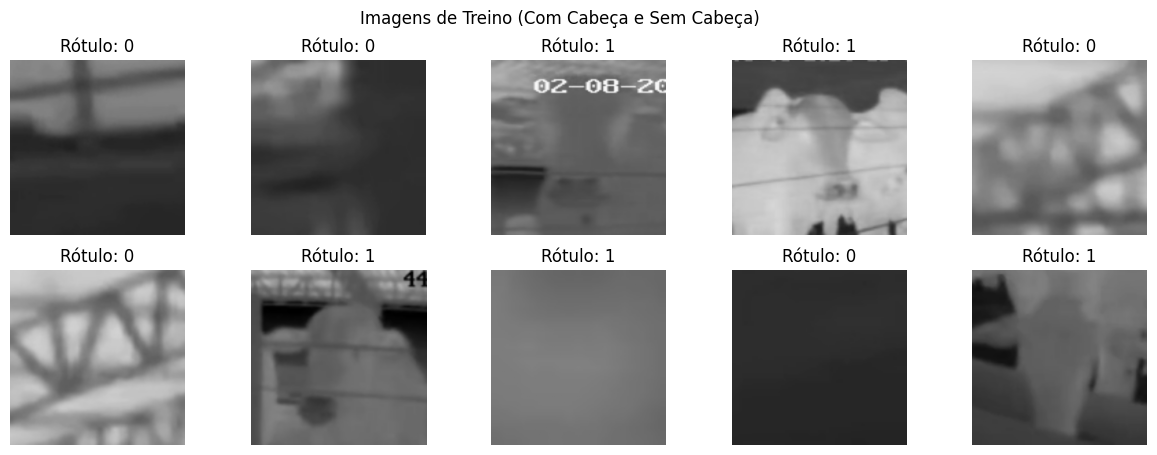

Imagens de teste (com cabeça e sem cabeça):


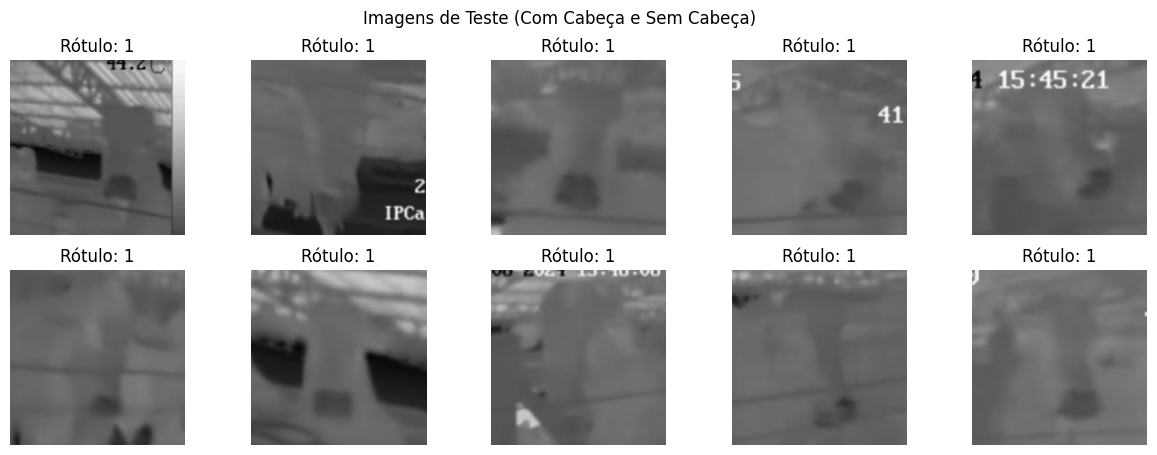

In [ ]:
import matplotlib.pyplot as plt

# Função para plotar uma grade de imagens
def plot_images(images, labels, num_images=10, title="Imagens"):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i])
        plt.title(f"Rótulo: {int(labels[i])}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plotar 10 imagens do conjunto de treino "com cabeça" e "sem cabeça"
print("Imagens de treino (com cabeça e sem cabeça):")
plot_images(X_train, y_train, num_images=10, title="Imagens de Treino (Com Cabeça e Sem Cabeça)")

# Plotar 10 imagens do conjunto de teste "com cabeça" e "sem cabeça"
print("Imagens de teste (com cabeça e sem cabeça):")
plot_images(X_test, y_test, num_images=10, title="Imagens de Teste (Com Cabeça e Sem Cabeça)")


In [ ]:
import numpy as np

# Contagem de imagens "com cabeça" e "sem cabeça" no conjunto de treino
num_com_cabeca_train = np.sum(y_train == 1)
num_sem_cabeca_train = np.sum(y_train == 0)

# Contagem de imagens "com cabeça" e "sem cabeça" no conjunto de teste
num_com_cabeca_test = np.sum(y_test == 1)
num_sem_cabeca_test = np.sum(y_test == 0)

# Contagem de imagens "com cabeça" e "sem cabeça" no conjunto de validação
num_com_cabeca_val = np.sum(y_val == 1)
num_sem_cabeca_val = np.sum(y_val == 0)

# Exibir os resultados
print(f"Treino - Imagens com cabeça: {num_com_cabeca_train}, Imagens sem cabeça: {num_sem_cabeca_train}")
print(f"Teste - Imagens com cabeça: {num_com_cabeca_test}, Imagens sem cabeça: {num_sem_cabeca_test}")
print(f"Validação - Imagens com cabeça: {num_com_cabeca_val}, Imagens sem cabeça: {num_sem_cabeca_val}")


Treino - Imagens com cabeça: 2461, Imagens sem cabeça: 1542
Teste - Imagens com cabeça: 774, Imagens sem cabeça: 480
Validação - Imagens com cabeça: 623, Imagens sem cabeça: 378


In [ ]:
# Função para verificar a normalização das imagens
def check_normalization(images):
    min_value = np.min(images)
    max_value = np.max(images)
    print(f"Valor mínimo dos pixels: {min_value}")
    print(f"Valor máximo dos pixels: {max_value}")

    # Verificar se todos os valores estão no intervalo [0, 1]
    if min_value >= 0.0 and max_value <= 1.0:
        print("As imagens estão normalizadas corretamente entre 0 e 1.")
    else:
        print("As imagens NÃO estão normalizadas corretamente. Os valores estão fora do intervalo [0, 1].")

# Verificar normalização no conjunto de treino
print("Conjunto de treino:")
check_normalization(X_train)

# Verificar normalização no conjunto de validação
print("\nConjunto de validação:")
check_normalization(X_val)

# Verificar normalização no conjunto de teste
print("\nConjunto de teste:")
check_normalization(X_test)


Conjunto de treino:
Valor mínimo dos pixels: 0.0
Valor máximo dos pixels: 1.0
As imagens estão normalizadas corretamente entre 0 e 1.

Conjunto de validação:
Valor mínimo dos pixels: 0.0
Valor máximo dos pixels: 1.0
As imagens estão normalizadas corretamente entre 0 e 1.

Conjunto de teste:
Valor mínimo dos pixels: 0.0
Valor máximo dos pixels: 1.0
As imagens estão normalizadas corretamente entre 0 e 1.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Criar o gerador de aumento de dados (apenas para o conjunto de treino)
data_augmentation = ImageDataGenerator(
    rotation_range=30,         # Rotação aleatória de até 30 graus
    width_shift_range=0.1,     # Deslocamento horizontal de até 10%
    height_shift_range=0.1,    # Deslocamento vertical de até 10%
    shear_range=0.2,           # Cisalhamento
    zoom_range=0.2,            # Zoom aleatório
    horizontal_flip=True,      # Flip horizontal
    fill_mode='nearest'        # Preencher pixels vazios após transformação
)

# Gerador de dados para o conjunto de treino
train_generator = data_augmentation.flow(
    X_train, y_train,
    batch_size=16,  # Tamanho do batch (você pode ajustar esse número)
    shuffle=True
)

# Para o conjunto de validação/teste, não aplicamos aumento de dados, apenas normalização
val_test_generator = ImageDataGenerator()

# Gerador de dados para validação e teste
val_generator = val_test_generator.flow(X_val, y_val, batch_size=16)
test_generator = val_test_generator.flow(X_test, y_test, batch_size=16)


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU


# Carregar o modelo EfficientNetB0 com pesos do ImageNet, excluindo a última camada
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Descongelar as últimas camadas do modelo base para fazer fine-tuning
base_model.trainable = False

# Adicionar camadas personalizadas no topo
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Camada de pooling global para reduzir a dimensionalidade
x = Dense(512)(x)  # Primeira camada densa
x = LeakyReLU(alpha=0.01)(x)  # Add LeakyReLU activation separately
x = Dropout(0.1)(x)  # Dropout para evitar overfitting
predictions = Dense(1, activation='sigmoid')(x)  # Camada final para classificação binária

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,705,956 (17.95 MB)

 Trainable params: 656,385 (2.50 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping para interromper o treinamento quando a performance parar de melhorar
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Checkpoint para salvar o melhor modelo com base no desempenho de validação
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Treinamento do modelo
history = model.fit(
    train_generator,  # Gerador de dados de treino com data augmentation
    validation_data=val_generator,  # Gerador de dados de validação
    epochs=50,  # Número máximo de épocas
    callbacks=[early_stopping, checkpoint],  # Early stopping e checkpoint
    verbose=1  # Exibe o progresso do treinamento
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


251/251 ━━━━━━━━━━━━━━━━━━━━ 87s 249ms/step - accuracy: 0.6095 - loss: 0.6782 - val_accuracy: 0.6224 - val_loss: 0.6633
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - accuracy: 0.6261 - loss: 0.6611 - val_accuracy: 0.6224 - val_loss: 0.6632
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 40s 155ms/step - accuracy: 0.6082 - loss: 0.6696 - val_accuracy: 0.6224 - val_loss: 0.6629
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 40s 154ms/step - accuracy: 0.6117 - loss: 0.6680 - val_accuracy: 0.6224 - val_loss: 0.6631
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 40s 154ms/step - accuracy: 0.6160 - loss: 0.6661 - val_accuracy: 0.6224 - val_loss: 0.6631
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 40s 154ms/step - accuracy: 0.6166 - loss: 0.6657 - val_accuracy: 0.6224 - val_loss: 0.6632
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 40s 154ms/step - accuracy: 0.6259 - loss: 0.6620 - val_accuracy: 0.6224 - val_loss: 0.6631
Epoch 8/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 39s 153ms/step - accuracy: 0.6152 - loss: 0.6671 - val

16/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6036 - loss: 0.6724

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.6239 - loss: 0.6621
Acurácia no conjunto de teste: 0.6172
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step
Relatório de Classificação:
              precision    recall  f1-score   support

  Sem Cabeça       0.00      0.00      0.00       480
  Com Cabeça       0.62      1.00      0.76       774

    accuracy                           0.62      1254
   macro avg       0.31      0.50      0.38      1254
weighted avg       0.38      0.62      0.47      1254



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


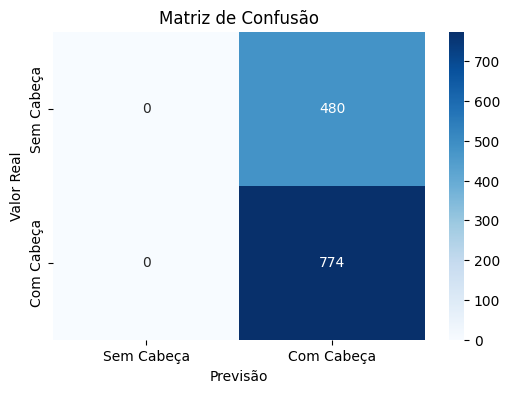

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Avaliar o modelo no conjunto de teste
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Acurácia no conjunto de teste: {test_acc:.4f}")

# Fazer previsões no conjunto de teste
y_pred = model.predict(test_generator)
y_pred_classes = np.round(y_pred).astype(int)  # Arredondar as previsões para 0 ou 1

# Relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred_classes, target_names=['Sem Cabeça', 'Com Cabeça']))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sem Cabeça', 'Com Cabeça'], yticklabels=['Sem Cabeça', 'Com Cabeça'])
plt.title("Matriz de Confusão")
plt.ylabel('Valor Real')
plt.xlabel('Previsão')
plt.show()


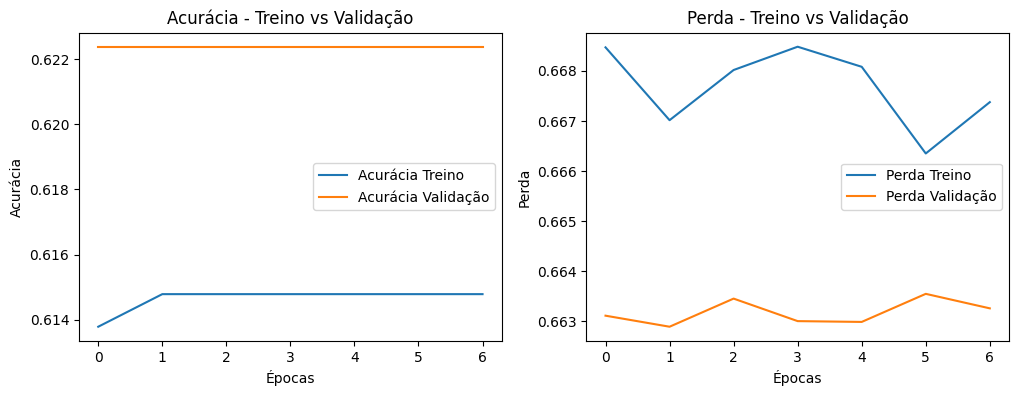

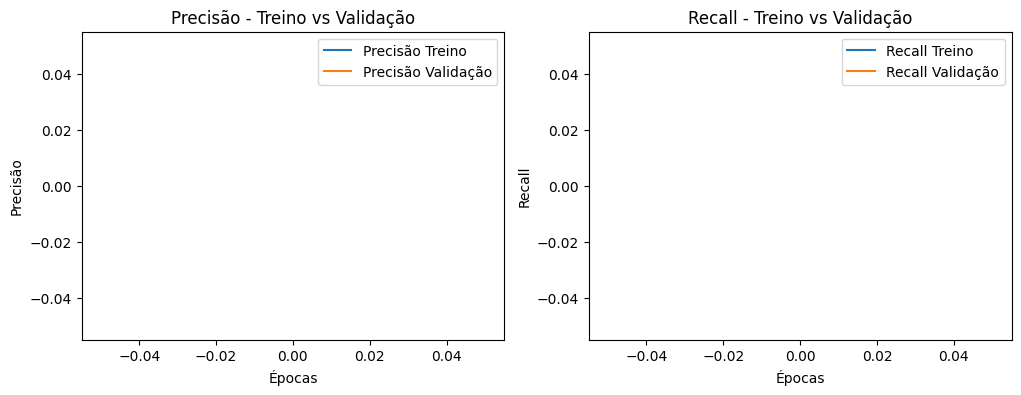

In [ ]:
import matplotlib.pyplot as plt

# Função para plotar a acurácia e perda do treino e validação
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plotar a Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia Treino')
    plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
    plt.title('Acurácia - Treino vs Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    # Plotar a Perda
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda Treino')
    plt.plot(history.history['val_loss'], label='Perda Validação')
    plt.title('Perda - Treino vs Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.show()

# Função para plotar as curvas de precisão e recall
def plot_precision_recall(history):
    plt.figure(figsize=(12, 4))

    # Plotar Precision (Precisão)
    plt.subplot(1, 2, 1)
    plt.plot(history.history.get('precision', []), label='Precisão Treino')
    plt.plot(history.history.get('val_precision', []), label='Precisão Validação')
    plt.title('Precisão - Treino vs Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Precisão')
    plt.legend()

    # Plotar Recall
    plt.subplot(1, 2, 2)
    plt.plot(history.history.get('recall', []), label='Recall Treino')
    plt.plot(history.history.get('val_recall', []), label='Recall Validação')
    plt.title('Recall - Treino vs Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Recall')
    plt.legend()

    plt.show()

# Plotar os resultados do histórico do modelo
plot_history(history)
plot_precision_recall(history)
